In [41]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import zscore
import matplotlib.pyplot as plt 
from statsmodels import regression
from statsmodels.tsa.stattools import coint

dados = pd.read_excel('dados_relatorio.xlsx')[1:]
# data_antigo = pd.read_excel('/home/daniel/Desktop/Projetos/mql_python/todos_diretorios_desenvolvimento_projeto/Relatório 1/dados_relatorio.xlsx')[1:] #linux
# dados = data_antigo.copy()
#dados = pd.read_excel('dados_antigo_copia.xlsx')[1:]

In [48]:
dados

,time,close IBOV,close ABEV3,close AZUL4,close B3SA3,close BBAS3,close BBDC3,close BBDC4,close BBSE3,close BEEF3,...,close TAEE11,close TIMP3,close TOTS3,close UGPA3,close USIM5,close VALE3,close VIVT4,close VVAR3,close WEGE3,close YDUQ3
1,2016-01-22,38031,15.08,NaN,8.97,10.96,8.97,8.37,15.14,11.53,...,10.14,5.60,8.93,25.66,0.95,8.17,25.62,NaN,10.49,8.67
2,2016-01-26,37497,15.07,NaN,8.89,10.87,8.97,8.28,14.47,11.23,...,10.28,5.42,9.06,24.80,0.92,8.09,25.21,1.11,10.10,8.43
3,2016-01-27,38376,15.94,NaN,9.17,10.71,9.15,8.38,14.51,11.38,...,10.77,5.72,9.22,25.61,0.86,8.51,26.04,1.11,10.51,8.49
4,2016-01-28,38630,16.01,NaN,9.26,10.95,9.31,8.39,14.98,11.58,...,10.98,5.49,9.42,25.82,0.82,8.44,25.62,1.23,10.48,8.39
5,2016-01-29,40406,16.70,NaN,9.17,11.68,9.50,8.75,15.93,11.94,...,11.37,5.78,10.12,26.60,0.81,8.79,26.24,1.22,11.00,9.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,2019-12-20,115121,18.91,57.00,47.96,50.45,30.09,32.23,34.54,12.08,...,29.52,15.20,22.70,24.30,9.24,53.59,55.25,11.37,33.69,47.23
971,2019-12-23,115863,18.96,57.60,45.78,51.98,30.70,32.43,34.73,12.07,...,29.71,15.31,22.44,25.01,9.44,53.38,55.74,11.67,33.63,48.09
972,2019-12-26,117203,19.22,57.07,45.57,52.57,31.02,32.83,34.56,12.64,...,30.05,15.51,22.28,25.28,9.44,53.59,56.23,11.80,34.68,47.70
973,2019-12-27,116534,19.16,57.80,43.19,52.34,30.82,32.71,34.63,12.74,...,29.97,15.51,21.56,25.40,9.34,53.60,55.84,11.50,35.17,47.90


In [64]:
class senninha_long_and_short():
    def __init__(self,dados,t1,t2, financeiro_inicial, zs_l):
        #temos o par de tickers, os dados históricos de preço, e as variações históricas.
        self.zs_critico = zs_l
        self.t1, self.t2 = t1,t2
        self.dados = dados[['time',t1,t2]]
        self.dados_var = dados[[t1,t2]].pct_change()[1:]
        self.dados = self.dados[1:]
        self.s1, self.s2 = self.dados[self.t1], self.dados[self.t2]
        self.s1_var, self.s2_var = self.dados_var[self.t1], self.dados_var[self.t2]
        self.financeiro = financeiro_inicial
        #variaveis iniciais para tradar pares
        self.posicionado = 0
        self.compra_s1 = 0
        self.venda_s2 = 0
        #desempenho ao longo do tempo 
        self.l_resultado = []
        self.l_pct_operacoes = []
        self.l_evolucao = []
          
    def calcula_zscore_spread(self,stock1,stock2):
        stock1 = sm.add_constant(stock1)
        results = sm.OLS(stock2,stock1).fit()
        stock1 = stock1[self.t1]
        b = results.params[self.t1]
        spread = stock2 - (b*stock1)
        zs = zscore(spread)[-1]
        return zs, b
    
    def print_resultados(self, tipo, r): #rlong,rshort,result
        if tipo == 'entrada':
            print(f'entrou | V1 {self.venda_s1:.2f} X {self.v1} | C2 {self.compra_s2:.2f} X {self.v2}')
        elif tipo == 'saida':
            print(f'saiu   | C1 {self.compra_s1:.2f} X {self.v1} | V2 {self.venda_s2:.2f} X {self.v2}')
        elif tipo == 'resultado':
            print(f'result | s1 {r[0]:.2f} | s2 {r[1]:.2f} | l/p = {r[2]:.2f}\n')
    
    def condicoes_operar(self, zs_atual, cotacao1, cotacao2):
        if zs_atual >= self.zs_critico and self.posicionado == 0:
            razao = cotacao1/cotacao2
            volume = (self.financeiro/2)//cotacao1
            self.v1, self.v2 = int(volume), int(razao*volume)
            #definiu o numero de ações que comprará de cada
            self.venda_s1 = cotacao1*self.v1
            self.compra_s2  = cotacao2*self.v2 
            self.valor_total_trade = self.venda_s1+self.compra_s2
            self.print_resultados('entrada',r=None)
            self.posicionado = 1
        elif zs_atual <= 0.08 and self.posicionado == 1:
            self.posicionado = 0            
            #encerra posicao
            self.compra_s1 = cotacao1*self.v1
            self.venda_s2  = cotacao2*self.v2 
            self.print_resultados('saida',r=None)
            #resultado
            resultado_long  = self.venda_s1 - self.compra_s1
            resultado_short = self.venda_s2 - self.compra_s2
            resultado = resultado_long + resultado_short
            pct_operacao = (resultado/self.valor_total_trade)*100
            #resultados ao longo do tempo
            self.l_pct_operacoes.append(pct_operacao)
            self.l_resultado.append(resultado)
            self.print_resultados('resultado',[resultado_long,resultado_short,resultado])
            self.financeiro += resultado
            #reseta valor em carteira de cada ação
            self.compra_s1, self.venda_s1, self.compra_s2 ,self.venda_s2,  = 0, 0, 0, 0
            resultado, resultado_long, resultado_short = 0, 0, 0
        self.l_evolucao.append(self.financeiro)

            
    def loop_operador(self, window_size):
        c = 0
        for index in range(window_size, len(self.s1)):
            #stock data in the window range
            s1_var_w, s2_var_w = self.s1_var[c:index], self.s2_var[c:index]
            preco_s1, preco_s2 = self.s1[self.dados.index == index].values[0], self.s2[self.dados.index == index].values[0]
            #calculates the zscore of the spread
            resultado_funcao = self.calcula_zscore_spread(s1_var_w, s2_var_w)
            zs, beta = resultado_funcao[0], resultado_funcao[1]
            self.condicoes_operar(zs_atual=zs, cotacao1=preco_s1, cotacao2=preco_s2)   
            c+=1

In [65]:
dic_dados_pares = {}

In [66]:
zsl = 1.1
tickers = [['close VALE3','close ITSA4'],['close ECOR3','close GOAU4'],['close CSNA3','close MRFG3'],['close QUAL3','close USIM5']] #['close VALE3','close ITSA4'],['close BBAS3','close BBSE3'],['close BBDC4','close ITUB4']
for i in tickers:
    dic_dados_pares[str(i)] = senninha_long_and_short(dados,i[0], i[1], 1000,zs_l = zsl)
    dic_dados_pares[str(i)].loop_operador(window_size=75)



entrou | V1 487.56 X 34 | C2 486.82 X 101
saiu   | C1 510.00 X 34 | V2 505.00 X 101
result | s1 -22.44 | s2 18.18 | l/p = -4.26

entrou | V1 492.66 X 34 | C2 492.48 X 96
saiu   | C1 497.76 X 34 | V2 506.88 X 96
result | s1 -5.10 | s2 14.40 | l/p = 9.30

entrou | V1 496.00 X 31 | C2 494.00 X 95
saiu   | C1 486.39 X 31 | V2 528.20 X 95
result | s1 9.61 | s2 34.20 | l/p = 43.81

entrou | V1 520.64 X 32 | C2 517.04 X 92
saiu   | C1 543.04 X 32 | V2 539.12 X 92
result | s1 -22.40 | s2 22.08 | l/p = -0.32

entrou | V1 523.52 X 32 | C2 520.52 X 91
saiu   | C1 533.44 X 32 | V2 544.18 X 91
result | s1 -9.92 | s2 23.66 | l/p = 13.74

entrou | V1 526.75 X 35 | C2 523.59 X 93
saiu   | C1 526.75 X 35 | V2 535.68 X 93
result | s1 0.00 | s2 12.09 | l/p = 12.09

entrou | V1 531.63 X 27 | C2 527.22 X 87
saiu   | C1 537.30 X 27 | V2 538.53 X 87
result | s1 -5.67 | s2 11.31 | l/p = 5.64

entrou | V1 520.52 X 26 | C2 514.60 X 83
saiu   | C1 519.22 X 26 | V2 535.35 X 83
result | s1 1.30 | s2 20.75 | l/p = 

entrou | V1 1889.55 X 39 | C2 1879.68 X 176
saiu   | C1 1878.24 X 39 | V2 1981.76 X 176
result | s1 11.31 | s2 102.08 | l/p = 113.39

entrou | V1 1987.05 X 39 | C2 1985.40 X 180
saiu   | C1 1980.42 X 39 | V2 2030.40 X 180
result | s1 6.63 | s2 45.00 | l/p = 51.63

entrou | V1 2004.40 X 40 | C2 1998.00 X 185
saiu   | C1 2028.80 X 40 | V2 2049.80 X 185
result | s1 -24.40 | s2 51.80 | l/p = 27.40

entrou | V1 2004.23 X 43 | C2 1999.48 X 193
saiu   | C1 1991.33 X 43 | V2 2126.86 X 193
result | s1 12.90 | s2 127.38 | l/p = 140.28

entrou | V1 2059.26 X 42 | C2 2055.80 X 190
saiu   | C1 2014.74 X 42 | V2 2215.40 X 190
result | s1 44.52 | s2 159.60 | l/p = 204.12

entrou | V1 2196.87 X 43 | C2 2190.51 X 189
saiu   | C1 2201.17 X 43 | V2 2237.76 X 189
result | s1 -4.30 | s2 47.25 | l/p = 42.95

entrou | V1 2208.36 X 44 | C2 2202.86 X 187
saiu   | C1 2216.72 X 44 | V2 2272.05 X 187
result | s1 -8.36 | s2 69.19 | l/p = 60.83

entrou | V1 2213.21 X 43 | C2 2202.20 X 182
saiu   | C1 2208.91 X 43 |

entrou | V1 3260.96 X 356 | C2 3254.31 X 459
saiu   | C1 3257.40 X 356 | V2 3538.89 X 459
result | s1 3.56 | s2 284.58 | l/p = 288.14

entrou | V1 3401.67 X 447 | C2 3399.50 X 523
saiu   | C1 3544.71 X 447 | V2 3593.01 X 523
result | s1 -143.04 | s2 193.51 | l/p = 50.47

entrou | V1 3424.86 X 477 | C2 3419.69 X 569
saiu   | C1 3472.56 X 477 | V2 3590.39 X 569
result | s1 -47.70 | s2 170.70 | l/p = 123.00

entrou | V1 3486.00 X 498 | C2 3480.51 X 583
saiu   | C1 3416.28 X 498 | V2 3556.30 X 583
result | s1 69.72 | s2 75.79 | l/p = 145.51

entrou | V1 3559.80 X 510 | C2 3558.06 X 599
saiu   | C1 3855.60 X 510 | V2 4007.31 X 599
result | s1 -295.80 | s2 449.25 | l/p = 153.45

entrou | V1 3639.44 X 469 | C2 3636.14 X 562
saiu   | C1 3705.10 X 469 | V2 3838.46 X 562
result | s1 -65.66 | s2 202.32 | l/p = 136.66

entrou | V1 3705.24 X 462 | C2 3701.44 X 538
saiu   | C1 3709.86 X 462 | V2 3938.16 X 538
result | s1 -4.62 | s2 236.72 | l/p = 232.10

entrou | V1 3824.82 X 486 | C2 3819.76 X 532


entrou | V1 656.19 X 69 | C2 653.13 X 123
saiu   | C1 610.65 X 69 | V2 731.85 X 123
result | s1 45.54 | s2 78.72 | l/p = 124.26

entrou | V1 721.71 X 99 | C2 718.90 X 130
saiu   | C1 658.35 X 99 | V2 738.40 X 130
result | s1 63.36 | s2 19.50 | l/p = 82.86

entrou | V1 758.74 X 118 | C2 758.70 X 135
saiu   | C1 749.30 X 118 | V2 811.35 X 135
result | s1 9.44 | s2 52.65 | l/p = 62.09

entrou | V1 789.76 X 128 | C2 784.08 X 132
saiu   | C1 847.36 X 128 | V2 892.32 X 132
result | s1 -57.60 | s2 108.24 | l/p = 50.64

entrou | V1 818.40 X 124 | C2 817.20 X 120
saiu   | C1 854.36 X 124 | V2 877.20 X 120
result | s1 -35.96 | s2 60.00 | l/p = 24.04

entrou | V1 829.47 X 129 | C2 824.73 X 111
saiu   | C1 847.53 X 129 | V2 868.02 X 111
result | s1 -18.06 | s2 43.29 | l/p = 25.23

entrou | V1 843.84 X 144 | C2 840.48 X 136
saiu   | C1 825.12 X 144 | V2 893.52 X 136
result | s1 18.72 | s2 53.04 | l/p = 71.76

entrou | V1 878.49 X 129 | C2 876.15 X 135
saiu   | C1 954.60 X 129 | V2 924.75 X 135
resu

saiu   | C1 4105.30 X 305 | V2 4588.98 X 561
result | s1 183.00 | s2 302.94 | l/p = 485.94

entrou | V1 4529.85 X 345 | C2 4525.30 X 590
saiu   | C1 4847.25 X 345 | V2 4926.50 X 590
result | s1 -317.40 | s2 401.20 | l/p = 83.80

entrou | V1 4582.08 X 333 | C2 4576.38 X 534
saiu   | C1 4728.60 X 333 | V2 4752.60 X 534
result | s1 -146.52 | s2 176.22 | l/p = 29.70

entrou | V1 4593.33 X 317 | C2 4586.09 X 509
saiu   | C1 4460.19 X 317 | V2 5008.56 X 509
result | s1 133.14 | s2 422.47 | l/p = 555.61

entrou | V1 4864.94 X 347 | C2 4860.98 X 493
saiu   | C1 4851.06 X 347 | V2 5423.00 X 493
result | s1 13.88 | s2 562.02 | l/p = 575.90

entrou | V1 5155.80 X 390 | C2 5146.34 X 467
saiu   | C1 5151.90 X 390 | V2 5440.55 X 467
result | s1 3.90 | s2 294.21 | l/p = 298.11

entrou | V1 5309.28 X 432 | C2 5308.30 X 487
saiu   | C1 5438.88 X 432 | V2 5522.58 X 487
result | s1 -129.60 | s2 214.28 | l/p = 84.68

entrou | V1 5349.24 X 468 | C2 5345.28 X 512
saiu   | C1 5424.12 X 468 | V2 5780.48 X 512

saiu   | C1 8002.80 X 684 | V2 8854.81 X 941
result | s1 41.04 | s2 818.67 | l/p = 859.71

entrou | V1 8477.01 X 719 | C2 8472.90 X 926
saiu   | C1 8225.36 X 719 | V2 8843.30 X 926
result | s1 251.65 | s2 370.40 | l/p = 622.05

entrou | V1 8782.13 X 763 | C2 8779.44 X 942
saiu   | C1 8370.11 X 763 | V2 9306.96 X 942
result | s1 412.02 | s2 527.52 | l/p = 939.54

entrou | V1 9258.88 X 736 | C2 9255.36 X 992
saiu   | C1 9332.48 X 736 | V2 9949.76 X 992
result | s1 -73.60 | s2 694.40 | l/p = 620.80

entrou | V1 9565.65 X 733 | C2 9557.00 X 1006
saiu   | C1 9565.65 X 733 | V2 9878.92 X 1006
result | s1 0.00 | s2 321.92 | l/p = 321.92

entrou | V1 9725.92 X 712 | C2 9721.60 X 980
saiu   | C1 9733.04 X 712 | V2 10045.00 X 980
result | s1 -7.12 | s2 323.40 | l/p = 316.28

entrou | V1 9883.41 X 723 | C2 9874.60 X 970
saiu   | C1 9818.34 X 723 | V2 10398.40 X 970
result | s1 65.07 | s2 523.80 | l/p = 588.87

entrou | V1 10180.17 X 791 | C2 10175.70 X 1070
saiu   | C1 10346.28 X 791 | V2 10742.8

['close VALE3', 'close ITSA4']: 5428.78
['close ECOR3', 'close GOAU4']: 19809.90
['close CSNA3', 'close MRFG3']: 11677.63
['close QUAL3', 'close USIM5']: 29998.95


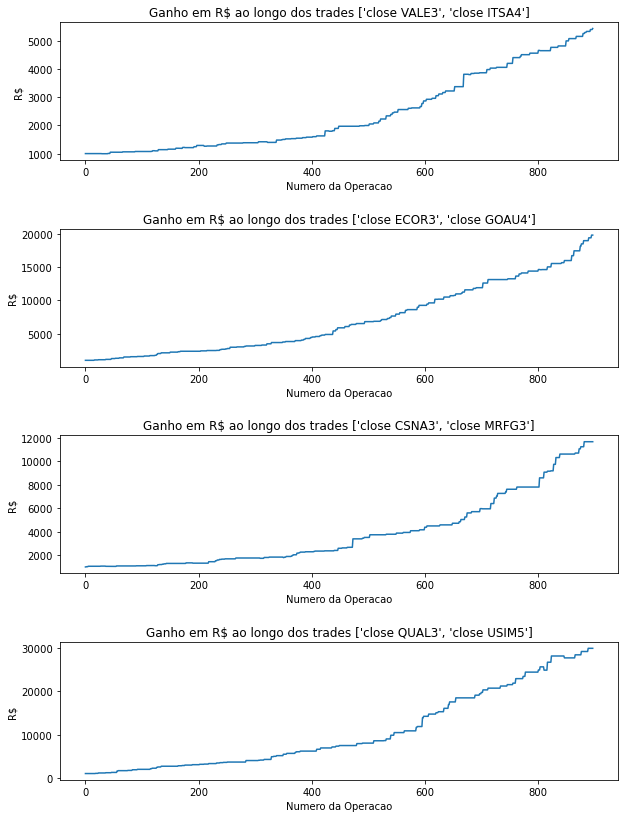

In [67]:
fig = plt.figure(figsize=(10, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
contador1 = 1

for k,v in dic_dados_pares.items():
    print(f'{k}: {v.financeiro:.2f}')
    plt.subplot(8, 1, contador1)
    plt.title('Ganho em R$ ao longo dos trades '+ k)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    plt.plot(v.l_evolucao)
    contador1 += 1

In [75]:
# fig = plt.figure(figsize=(10, 25))
# plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
# contador1 = 1
tamanho = len(dic_dados_pares["['close VALE3', 'close ITSA4']"].l_evolucao)
l_carteira_total = [0]*tamanho

for i in range(tamanho):
    l_carteira_total[i] = 0
    for k,v in dic_dados_pares.items():
        l_carteira_total[i] += v.l_evolucao[i]
#     print(f'{k}: {v.financeiro:.2f}')
#     plt.subplot(8, 1, contador1)
#     plt.title('Ganho em R$ ao longo dos trades '+ k)
#     plt.xlabel('Numero da Operacao')
#     plt.ylabel('R$')
#     plt.plot(v.l_evolucao)
#     contador1 += 1

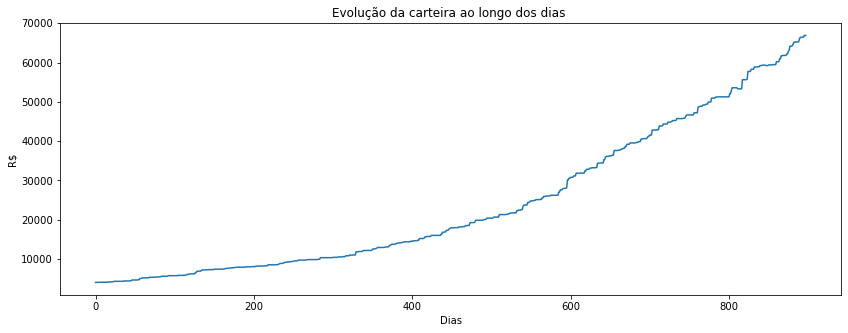

In [81]:
fig = plt.figure(figsize=(14, 5))
plt.title('Evolução da carteira ao longo dos dias ')
plt.xlabel('Dias')
plt.ylabel('R$')
plt.plot(l_carteira_total)
plt.show()